In [54]:
# !pip install PyPortfolioOpt==1.2.5 
# !pip install cvxpy==1.1
# !pip install --upgrade firebase-admin
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
#style.use('fivethirtyeight')  k chay
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(10,6)})
%config InlineBackend.figure_format = 'retina'


In [55]:
import pandas as pd
portfolio_api = pd.read_json("https://danhmuc.herokuapp.com/lists/1/risk_analysis.json")
rails = pd.DataFrame(portfolio_api)
tickers = []
for i in range(len(rails.security)):
  tickers.append(rails.security[i]['ticker'])
tickers 
portfolio_api.list_id.unique().tolist()
print(portfolio_api)

    id  security_id  list_id                       created_at  \
0  202          220        1 2020-09-08 09:34:27.573000+07:00   
1  204          389        1 2020-09-08 09:34:39.228000+07:00   
2  205           86        1 2020-09-08 09:45:41.193000+07:00   
3  208          155        1 2020-09-08 15:46:42.629000+07:00   

                        updated_at  price  signal  quantity           security  
0 2020-09-08 09:34:27.573000+07:00  22750     NaN        10  {'ticker': 'NT2'}  
1 2020-09-08 09:34:39.228000+07:00  33600     NaN        10  {'ticker': 'VSC'}  
2 2020-09-08 09:45:41.193000+07:00  16100     NaN        10  {'ticker': 'DPM'}  
3 2020-09-08 15:46:42.629000+07:00  24600     NaN        10  {'ticker': 'HPG'}  


In [56]:
start_date = '2013-01-01'
stock_list = tickers
#stock_list = [ 'VCB', 'HPG','MWG']
#stock_list = ['PNJ', 'VIC', 'FPT', 'VCB', 'MWG'] #'MWG', 'HPG', 'PNJ', 'REE', 'FPT'
#stock_list = [ 'VCB', 'CTG', 'BID', 'ACB', 'MBB', 'SHB'] # underperform
#stock_list = ["BID", "BVH", "CTD", "CTG", "EIB", "FPT", "GAS", "HDB", "HPG", "MBB", "MSN", "MWG", "NVL", "PLX", "PNJ", "POW", "REE", "ROS", "SAB", "SBT", "SSI", "STB", "TCB", "VCB", "VHM", "VIC", "VJC", "VNM", "VPB", "VRE"]
numstocks = len(stock_list)
data_index = pd.read_csv('/content/drive/My Drive/data_analyst/data_index2012.csv')
data_index = data_index[['Ticker', 'Date', 'Close', 'AdjRatio']] #, 'Shares'
data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index = data_index[ (data_index.Ticker.isin(stock_list)) & (data_index['Date'] >= start_date) ] #& (data_index['Date'] < '2020-04-01')
data_index['Adj_Close'] = data_index['Close'] / data_index['AdjRatio']
#data_index['Mcap'] = data_index['Close'] * data_index['Shares']
print(data_index.tail(5))

#pivot
data_index_pivot = data_index.pivot(columns='Ticker', index='Date', values='Adj_Close')
returns = data_index_pivot.pct_change()
avg_daily_return = returns.mean()

        Ticker       Date    Close  AdjRatio  Adj_Close
2428365    VSC 2020-08-21  32850.0       1.0    32850.0
2428782    DPM 2020-08-24  15850.0       1.0    15850.0
2429021    HPG 2020-08-24  24800.0       1.0    24800.0
2429334    NT2 2020-08-24  22800.0       1.0    22800.0
2430002    VSC 2020-08-24  33150.0       1.0    33150.0


In [57]:
%%time
#%%timeit -r 1 -n 20
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

EOM  = data_index_pivot.copy()
EOM_resample = EOM.resample('BMS').ffill()  #BQ business quarter end, BQS business quarter start, BMS month start
reb_date = list(EOM.resample('BMS').ffill().index)
#last reb là ngày cuối quý trước
if reb_date[-1] > pd.Timestamp.today():
  reb_date.pop()
weights_dfs = pd.DataFrame()
weights_RP_dfs = pd.DataFrame()
for i in range(24,len(reb_date)):
    print(reb_date[i])
    df = EOM.loc[:reb_date[i]].dropna(axis='columns', thresh=300).tail(100)
    risk_parity_weights = get_weights(df)
    risk_parity_weights_df = pd.DataFrame(risk_parity_weights).reset_index().rename(columns={'weight': 'weights_RP'})
    risk_parity_weights_df['Date'] = reb_date[i]
    weights_RP_dfs = weights_RP_dfs.append(risk_parity_weights_df)

    print(df.head(1))
    print('last row cum return==============')
    print( ((df.pct_change() + 1).cumprod() -1).tail(1) )
    if ((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0] >0.01:
      print("--total return {}".format(((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0]))
       
      try:
        mu = expected_returns.mean_historical_return(df)
        S = risk_models.sample_cov(df)
          # Optimise for maximal Sharpe ratio
        ef = EfficientFrontier(mu, S, weight_bounds=(0,0.8))   
          #ef.add_constraint(lambda x : x >= 0.01)
        raw_weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        print(cleaned_weights)
        ef.portfolio_performance(verbose=True)
        weights_df = pd.DataFrame({"weights": list(cleaned_weights.values()), "Ticker": list(cleaned_weights.keys())})
        weights_df =  weights_df[weights_df["weights"] != 0].reset_index(drop=True)
        weights_reb = weights_df
        weights_reb['Date'] = reb_date[i]
        weights_dfs = weights_dfs.append(weights_reb)  
        weights_plot = weights_df.set_index("Ticker", drop=True) # dùng để vẽ đồ thị
        pd.DataFrame(c).reset_index()

      except:
        print("Không đủ dữ liệu")
        pass    
      #weights_plot['weights'].plot(kind='bar', title="{}".format(reb_date[i]))
      print("====================================================")

2015-01-01 00:00:00
Ticker              DPM          HPG          NT2           VSC
Date                                                           
2014-08-12  16197.65028  8550.455784  4049.882897  28057.208672
last row cum return==============
Ticker           DPM       HPG      NT2       VSC
Date                                             
2014-12-31  0.108188 -0.045045  1.41391 -0.106099
--total return 1.3709545359445692
OrderedDict([('DPM', 0.2), ('HPG', 0.0), ('NT2', 0.8), ('VSC', 0.0)])
Expected annual return: 679.8%
Annual volatility: 47.4%
Sharpe Ratio: 14.29
2015-02-02 00:00:00
Ticker               DPM         HPG          NT2           VSC
Date                                                           
2014-09-12  18980.751702  8935.61145  5688.037777  28795.556269
last row cum return==============
Ticker           DPM       HPG       NT2       VSC
Date                                              
2015-02-02 -0.075796 -0.181034  0.825609 -0.146439
--total return 0.42233982

In [58]:
data_index_opt = data_index.copy()
data_index_opt['Month'] = data_index_opt['Date'].dt.month
data_index_opt['Year'] = data_index_opt['Date'].dt.year
weights_dfs['Uni'] = 1
weights_dfs['Month'] = weights_dfs['Date'].dt.month
weights_dfs['Year'] = weights_dfs['Date'].dt.year

#risk parity
weights_RP_dfs['Uni_RP'] = 1
weights_RP_dfs['Month'] = weights_RP_dfs['Date'].dt.month
weights_RP_dfs['Year'] = weights_RP_dfs['Date'].dt.year


In [59]:
data_index_opt = pd.merge(data_index_opt, weights_dfs.loc[:, weights_dfs.columns != 'Date'], how='left', on=['Ticker', 'Month', 'Year']) #merrge w, y
data_index_opt['Uni']= data_index_opt['Uni'].fillna(0)


#risk parity
data_index_opt = pd.merge(data_index_opt, weights_RP_dfs.loc[:, weights_dfs.columns != 'Date'], how='left', on=['Ticker', 'Month', 'Year']) #merrge w, y
data_index_opt['Uni_RP']= data_index_opt['Uni_RP'].fillna(0)

data_index_opt.to_csv("data_index_opt.csv")

In [60]:
#data_index_opt[data_index_opt["Date"] >= '2016-04-01'].tail(100)

In [61]:
a= data_index_opt.copy() #[data_index_opt['Ticker'].isin(['BID', 'VIC', 'VCB'])]
a=a[(a['Date'] >= '2015-01-01') ] # & (a['Date'] <='2020-01-02')  2013-01-01 start_date
a['return'] = a.groupby('Ticker')['Adj_Close'].apply(lambda x: (x/x.shift(1)) - 1).copy()
((a.groupby('Ticker')['return'].mean())  / a.groupby('Ticker')['return'].std() ) * np.sqrt(252)

portfolio = a.groupby("Date").apply(lambda row: (row['return'] * row['weights']).sum())
portfolio_RP = a.groupby("Date").apply(lambda row: (row['return'] * row['weights_RP']).sum())

In [62]:
vn30_ew  = data_index_pivot.ffill().copy()
vn30_returns = vn30_ew.pct_change()
vn30_weghts_ew = np.repeat(1/numstocks, numstocks) #bị sai vì chưa đủ 30 mã
vn30_port_returns = vn30_returns.dot(vn30_weghts_ew)
vn30_port_returns_df = pd.DataFrame({"{}".format(', '.join(stock_list)): vn30_port_returns})

In [63]:
index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
index_price['Date'] = pd.to_datetime(index_price['Date'], format='%Y-%m-%d')
vn30_index = index_price[index_price['Ticker'] == 'VN30'][['Date', 'Close']].set_index('Date').rename(columns={'Close': 'VN30'})

In [64]:
type(portfolio)
portfolio_df = pd.DataFrame({"optimized": portfolio})
portfolio_RP_df = pd.DataFrame({"optimized_RP": portfolio_RP})
#portfolio_df
combine_portfolio = pd.merge(portfolio_df, vn30_index.pct_change(), on='Date', how='left')
#merge tiep vn30_ew, kha nang bi sai, thieu ma
combine_portfolio = pd.merge(combine_portfolio, vn30_port_returns_df, on='Date', how='left')

combine_portfolio = pd.merge(combine_portfolio, portfolio_RP_df, on='Date', how='left')

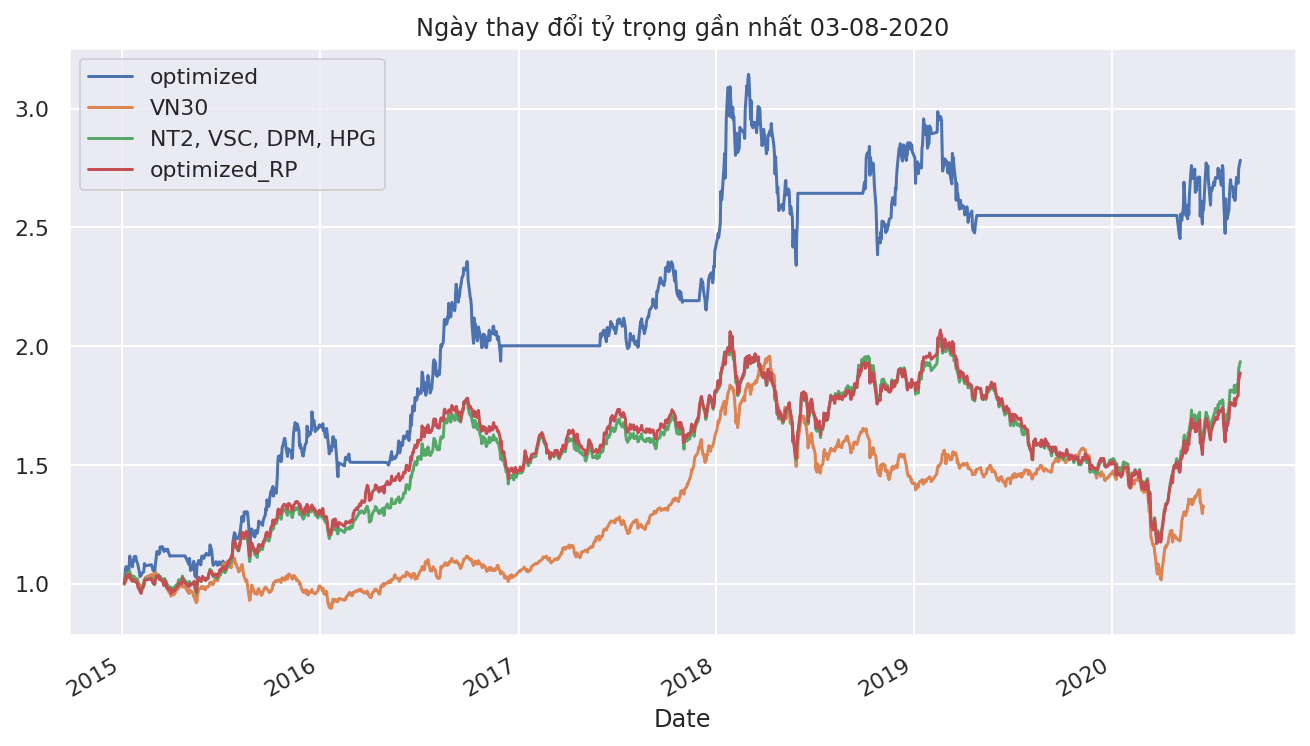

In [65]:
last_reb_date = weights_dfs.Date.max().strftime('%d-%m-%Y')  #, %r
(combine_portfolio+1).cumprod().plot(title="Ngày thay đổi tỷ trọng gần nhất {}".format(last_reb_date))

fig1 = plt.gcf()
fig1.set_size_inches(11,6)
fig1.savefig('mkw.jpg',dpi=120,bbox_inches='tight')

                   weights  Uni  Month  Year
Date       Ticker                           
2019-01-01 DPM     0.80000    1      1  2019
           NT2     0.06936    1      1  2019
           VSC     0.13064    1      1  2019
2019-02-01 DPM     0.63328    1      2  2019
           NT2     0.36672    1      2  2019
2019-03-01 DPM     0.22929    1      3  2019
           NT2     0.77071    1      3  2019
2019-04-01 DPM     0.25262    1      4  2019
           NT2     0.74738    1      4  2019
2020-05-01 DPM     0.62614    1      5  2020
           VSC     0.37386    1      5  2020
2020-06-01 DPM     0.65118    1      6  2020
           HPG     0.34882    1      6  2020
2020-07-01 DPM     0.80000    1      7  2020
           HPG     0.20000    1      7  2020
2020-08-03 DPM     0.04244    1      8  2020
           HPG     0.35622    1      8  2020
           VSC     0.60134    1      8  2020


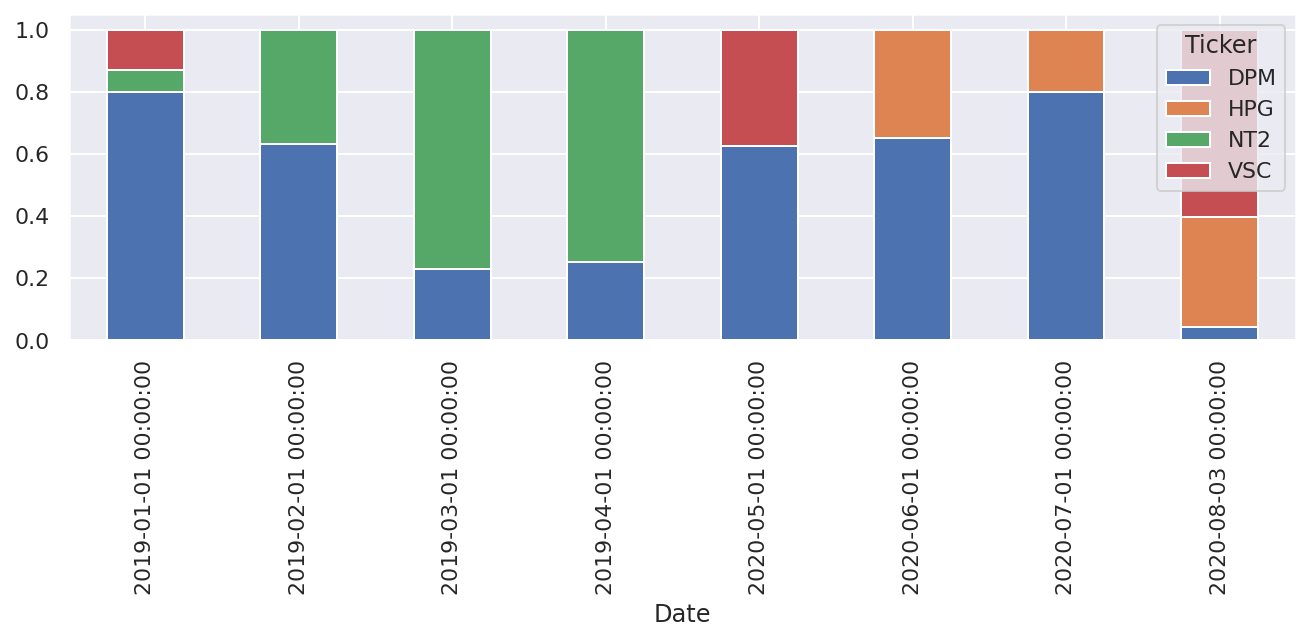

In [66]:
#strftime('%d-%m-%Y')
reb_plot =weights_dfs[weights_dfs['Date'].between('2019-01-01', weights_dfs['Date'].max())].set_index(['Date', 'Ticker'])
reb_plot['weights'].unstack().plot.bar(figsize =(17, 5),stacked=True)
print(reb_plot)
#print(reb_plot.index.get_level_values(0).strftime('%d-%m-%Y'))
#weights_dfs
fig2 = plt.gcf()
fig2.set_size_inches(11,3)
fig2.savefig('mkw_allocation.jpg',dpi=120,bbox_inches='tight')

                   weights_RP  Uni_RP  Month  Year
Date       Ticker                                 
2019-01-01 DPM       0.286597       1      1  2019
           HPG       0.179936       1      1  2019
           NT2       0.351046       1      1  2019
           VSC       0.182421       1      1  2019
2019-02-01 DPM       0.271715       1      2  2019
...                       ...     ...    ...   ...
2020-07-01 VSC       0.227823       1      7  2020
2020-08-03 DPM       0.282406       1      8  2020
           HPG       0.144900       1      8  2020
           NT2       0.276461       1      8  2020
           VSC       0.296233       1      8  2020

[80 rows x 4 columns]


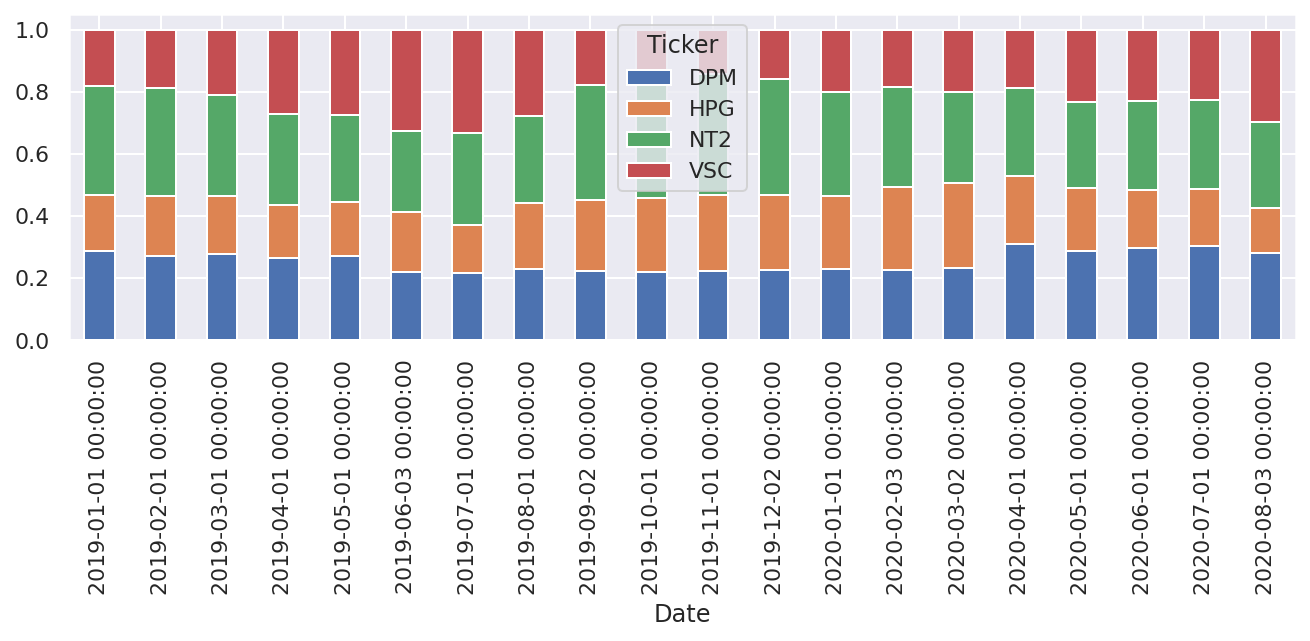

In [67]:
reb_RP_plot =weights_RP_dfs[weights_RP_dfs['Date'].between('2019-01-01', weights_RP_dfs['Date'].max())].set_index(['Date', 'Ticker'])
reb_RP_plot['weights_RP'].unstack().plot.bar(figsize =(17, 5),stacked=True)
print(reb_RP_plot)
fig3 = plt.gcf()
fig3.set_size_inches(11,3)
fig3.savefig('RP_allocation.jpg',dpi=120,bbox_inches='tight')

In [68]:

#weights_dfs.to_csv("vn30_optimized_weights.csv")
#weights_dfs.tail(30)

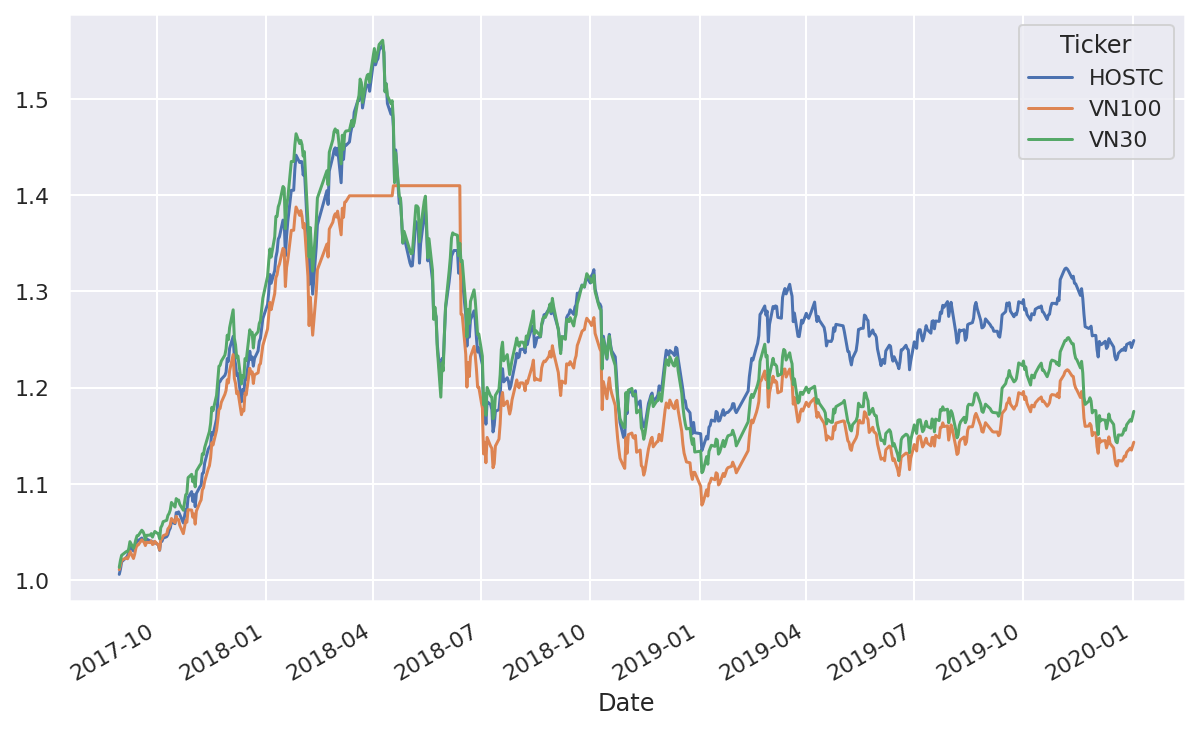

In [69]:
# so sánh index
index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
index_pivot = index_price.pivot(index="Date", columns="Ticker", values="Close")
index_pivot = index_pivot['2017-08-29':'2020-01-02'][['HOSTC', 'VN100', 'VN30']]
index_pivot
return_index = index_pivot.pct_change()
#return_index['VN100'].dropna()
cum_ret = (return_index + 1).cumprod().dropna()
cum_ret.plot()
#return_index[['HOSTC', 'VN100', 'VN30', 'VNALL']].cumprod()

In [70]:
#end 

In [71]:
#firebase 
import datetime
import threading
from time import sleep

import requests
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from firebase_admin import storage

# Use a service account

# cred = credentials.Certificate("/content/drive/My Drive/data_analyst/service-key-flask-api.json")

# cred = credentials.Certificate("/content/drive/My Drive/data_analyst/service-key.json") #real-time-db
# firebase_admin.initialize_app(cred, {
#     'storageBucket': 'test-realtime-db-ca644.appspot.com'
# })
# db = firestore.client()
# bucket = storage.bucket()

In [72]:
# xử lý weights để push lên
weights_dfs
weight_push = weights_dfs[weights_dfs['Date'] == weights_dfs.Date.max()][['Ticker', 'weights']].set_index('Ticker')
weight_dict = weight_push.to_dict()
weight_dict['weights']

{'DPM': 0.04244, 'HPG': 0.35622, 'VSC': 0.60134}

In [73]:
doc_ref = db.collection('list1').document('weights')
doc_ref.set(
    weight_dict['weights']
)

update_time {
  seconds: 1599619963
  nanos: 465278000
}

In [74]:
imageBlob = bucket.blob("mkw.jpg")
imageBlob.upload_from_filename("/content/mkw.jpg")
print(imageBlob.public_url)

imageBlob2 = bucket.blob("mkw_allocation.jpg")
imageBlob2.upload_from_filename("/content/mkw_allocation.jpg")
print(imageBlob2.public_url)

https://storage.googleapis.com/test-realtime-db-ca644.appspot.com/mkw.jpg
https://storage.googleapis.com/test-realtime-db-ca644.appspot.com/mkw_allocation.jpg


In [75]:
doc_ref = db.collection('lists')
docs = doc_ref.stream()

for doc in docs:
    print(f'{doc.id} => {doc.to_dict()}')

1 => {'user_id': 1, 'rebnum': 4, 'rebalance': True, 'name': 'Blah', 'created_date': '2020-09-07'}
list1 => {'weights': {'VCB': 0.3}, 'created_date': '2020-09-07', 'rebnum': 3, 'user_id': 1, 'name': 'LTI', 'rebalance': True}
list2 => {'user_id': 2, 'created_date': '2020-09-07', 'name': 'Blah'}
list3 => {'user_id': 1, 'created_date': '2020-09-07', 'name': 'Blah', 'rebalance': True, 'rebnum': 4}
stock-item1 => {'item1': 'VCB', 'item2': 'DHG'}


In [76]:
from scipy.optimize import minimize
TOLERANCE = 1e-10


def _allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # It returns the risk of the weights distribution
    return portfolio_risk


def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution


def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = \
        _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the
    # weights distribution
    assets_risk_target = \
        np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of
    # each asset
    error = \
        sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error


def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})

    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights


def get_weights(df):

    # We download the prices from Yahoo Finance
    prices = df.copy()

    # We calculate the covariance matrix
    covariances = 52.0 * \
        prices.asfreq('W-FRI').pct_change().iloc[1:, :].cov().values

    # The desired contribution of each asset to the portfolio risk: we want all
    # asset to contribute equally
    assets_risk_budget = [1 / prices.shape[1]] * prices.shape[1]

    # Initial weights: equally weighted
    init_weights = [1 / prices.shape[1]] * prices.shape[1]

    # Optimisation process of weights
    weights = \
        _get_risk_parity_weights(covariances, assets_risk_budget, init_weights)

    # Convert the weights to a pandas Series
    weights = pd.Series(weights, index=prices.columns, name='weight')

    # It returns the optimised weights
    return weights


In [77]:
import pandas_datareader.data as web
yahoo_tickers=['GOOGL', 'AAPL', 'AMZN']
start_date=datetime.datetime(2016, 10, 31)
end_date=datetime.datetime(2017, 10, 31)
prices = pd.DataFrame([web.DataReader(t,
                                          'yahoo',
                                          start_date,
                                          end_date).loc[:, 'Adj Close']
                           for t in yahoo_tickers],
                          index=yahoo_tickers).T.asfreq('B').ffill()

In [78]:
prices

,GOOGL,AAPL,AMZN
Date,,,
2016-10-31,809.900024,26.791819,789.820007
2016-11-01,805.479980,26.308084,785.409973
2016-11-02,788.419983,26.331680,765.559998
2016-11-03,782.190002,26.049444,767.030029
2016-11-04,781.099976,25.814631,755.049988
...,...,...,...
2017-10-25,991.460022,37.558807,972.909973
2017-10-26,991.419983,37.798935,972.429993
2017-10-27,1033.670044,39.153267,1100.949951


In [79]:
risk_parity_weights = get_weights(df)
risk_parity_weights

Ticker
DPM    0.282406
HPG    0.144900
NT2    0.276461
VSC    0.296233
Name: weight, dtype: float64

In [80]:
c = risk_parity_weights
c = pd.DataFrame(c).reset_index().rename(columns={'weight': 'weights_RP'})
c

,Ticker,weights_RP
0,DPM,0.282406
1,HPG,0.144900
2,NT2,0.276461
3,VSC,0.296233


In [81]:
weights_RP_dfs

,Ticker,weights_RP,Date,Uni_RP,Month,Year
0,DPM,0.225494,2015-01-01,1,1,2015
1,HPG,0.214042,2015-01-01,1,1,2015
2,NT2,0.130387,2015-01-01,1,1,2015
3,VSC,0.430077,2015-01-01,1,1,2015
0,DPM,0.244538,2015-02-02,1,2,2015
...,...,...,...,...,...,...
3,VSC,0.227823,2020-07-01,1,7,2020
0,DPM,0.282406,2020-08-03,1,8,2020
1,HPG,0.144900,2020-08-03,1,8,2020
2,NT2,0.276461,2020-08-03,1,8,2020


In [82]:
combine_portfolio

,optimized,VN30,"NT2, VSC, DPM, HPG",optimized_RP
Date,,,,
2015-01-05,0.000000,-0.003274,0.001247,0.000000
2015-01-06,0.021080,0.011139,0.014859,0.011886
2015-01-07,0.038805,0.002111,0.012467,0.008122
2015-01-08,0.009524,-0.001317,-0.000185,-0.003083
2015-01-09,0.000198,0.019049,0.015340,0.019816
...,...,...,...,...
2020-08-18,-0.003451,NaN,0.001820,0.002848
2020-08-19,-0.003812,NaN,0.002192,0.001737
2020-08-20,-0.002056,NaN,-0.000105,0.000719
